# Iris Dataset Testing

In [1]:
import sys  
sys.path.insert(0, '../')
import deep_forest
import preprocess
import torch as th
from torch import nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns
from tqdm import tqdm
sns.set_theme("notebook")
sns.set_style('whitegrid')

## Generate Data
The data is the UCl iris dataset. Here, 100% of the data is used for training.

In [2]:
train_data, train_labels, test_data, test_labels = preprocess.get_data(100)

## Deep Forest
Here, the model is instantiated (using cuda or the CPU) and trained.

In [3]:
model = deep_forest.DeepForest(100, 2, 4, 0.5, 10)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
train_data = train_data.to(device)
train_labels = train_labels.to(device)

In [4]:
optimizer = th.optim.Adam(model.parameters())
pbar = tqdm(range(2500))
for i in pbar:
    model.populate_best(train_data[:, :], train_labels[:])
    optimizer.zero_grad()
    
    loss = model.loss(train_data[:, :], train_labels[:], device)
    loss.backward()
    optimizer.step()
    
    pbar.set_description("EPOCH %d || Acc: %s || Loss: %s" % (i, str(th.mean((model.forward(train_data[:, :], device) == train_labels[:]).float())), str(loss)))
    
print("\n==============\nFINAL ACC: %s" % str(th.mean((model.forward(train_data[:, :], device) == train_labels[:]).float())))

  0%|          | 0/2500 [00:00<?, ?it/s]Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH 2499 || Acc: tensor(0.9533) || Loss: tensor([618.0315], grad_fn=<AddBackward0>): 100%|██████████| 2500/2500 [23:46<00:00,  1.75it/s]


FINAL ACC: tensor(0.9533)


In [6]:
imp = model.compute_importance(train_data)
print()
print(imp)

100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


defaultdict(<function DeepForest.__init__.<locals>.<lambda> at 0x7fb6b950f2f0>, {2: 0.3712712597497444, 0: 0.16501402181890648, 1: 0.10088812008724544, 3: 0.3628265983441037})


Text(0.5, 1.0, 'Iris Deep Forest Importance')

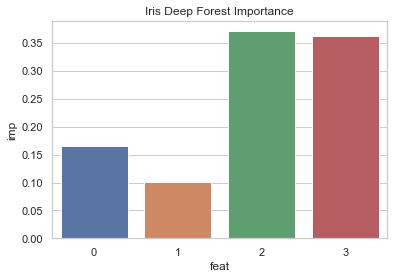

In [7]:
import pandas as pd
data = pd.DataFrame({"feat": list(imp.keys()), "imp": list(imp.values())})
sns.barplot(x="feat", y="imp", data=data).set_title("Iris Deep Forest Importance")

# MLP Baseline
Here, a baseline feedforward is used on thr Iris dataset for comparison.

In [9]:
mlp = nn.Sequential(
    nn.Linear(4, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 3),
    nn.Softmax()
)

optimizer = th.optim.Adam(mlp.parameters())
pbar = tqdm(range(1000))
for i in pbar:
    optimizer.zero_grad()

    preds = mlp(train_data[:, :])
    loss = nn.functional.cross_entropy(preds, (train_labels[:].type(th.LongTensor)).to(device))
    loss.backward()
    optimizer.step()

    pbar.set_description("EPOCH %d || Acc: %s || Loss: %s" % (i, str(th.mean((th.argmax(mlp(train_data), 1) == train_labels).float())), str(loss)))

print("\n\n==============\nFINAL ACC: %s" % str(th.mean((th.argmax(mlp(train_data[:]), 1) == train_labels[:]).float())))


EPOCH 999 || Acc: tensor(0.9533) || Loss: tensor(0.5705, grad_fn=<NllLossBackward>): 100%|██████████| 1000/1000 [01:54<00:00,  8.77it/s]


FINAL ACC: tensor(0.9867)


# Standard Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2)
clf.fit(train_data[:, :].numpy(), train_labels[:].numpy())
print("Accuracy: " + str(clf.score(train_data[:, :].numpy(), train_labels[:].numpy())))

Accuracy: 0.96


Text(0.5, 1.0, 'Iris Random Forest Importance')

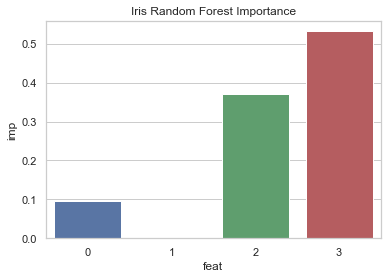

In [13]:
data = pd.DataFrame({"feat": list(range(4)), "imp": clf.feature_importances_})
sns.barplot(x="feat", y="imp", data=data).set_title("Iris Random Forest Importance")